# Colon Cancer Example

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import torch
sys.path.append(os.path.join(os.pardir))
from Code import nonparamcdf as npcdf
from Code import kernel
data_dir = os.path.join(os.pardir, "RealData")
plt.rc('font',**{'family':'sans-serif'})
#If fonttype = 1 doesn't work with LaTeX, try fonttype 42.
plt.rc('pdf',fonttype = 42)
plt.rc('ps',fonttype = 42)
plt.rcParams['figure.dpi'] = 140

# Untreated vs Any with Age

In [2]:
# Read data from .dta file
colon = pd.read_csv(os.path.join(data_dir, "colon.csv"))

In [3]:
y = torch.tensor(colon["time"].to_numpy()).float()
X = torch.tensor(colon["age"].to_numpy()).float().unsqueeze(-1)
a = torch.tensor((colon["rx"]!="Obs").to_numpy()).float()
censor = torch.tensor(colon["status"].to_numpy()).float()

print(torch.any(torch.isnan(y)))
print(torch.any(torch.isnan(X)))

# Split data by a
X0 = X[a == 0.,:]
X1 = X[a == 1.,:]
y0 = y[a == 0.]
y1 = y[a == 1.]
print(f"Number of y0 samples {y0.shape}")
print(f"Number of y1 samples {y1.shape}")

tensor(False)
tensor(False)
Number of y0 samples torch.Size([315])
Number of y1 samples torch.Size([614])


In [4]:
torch.max(y)

tensor(3329.)

Text(0.5, 0, 'Death/Reccurrence Time')

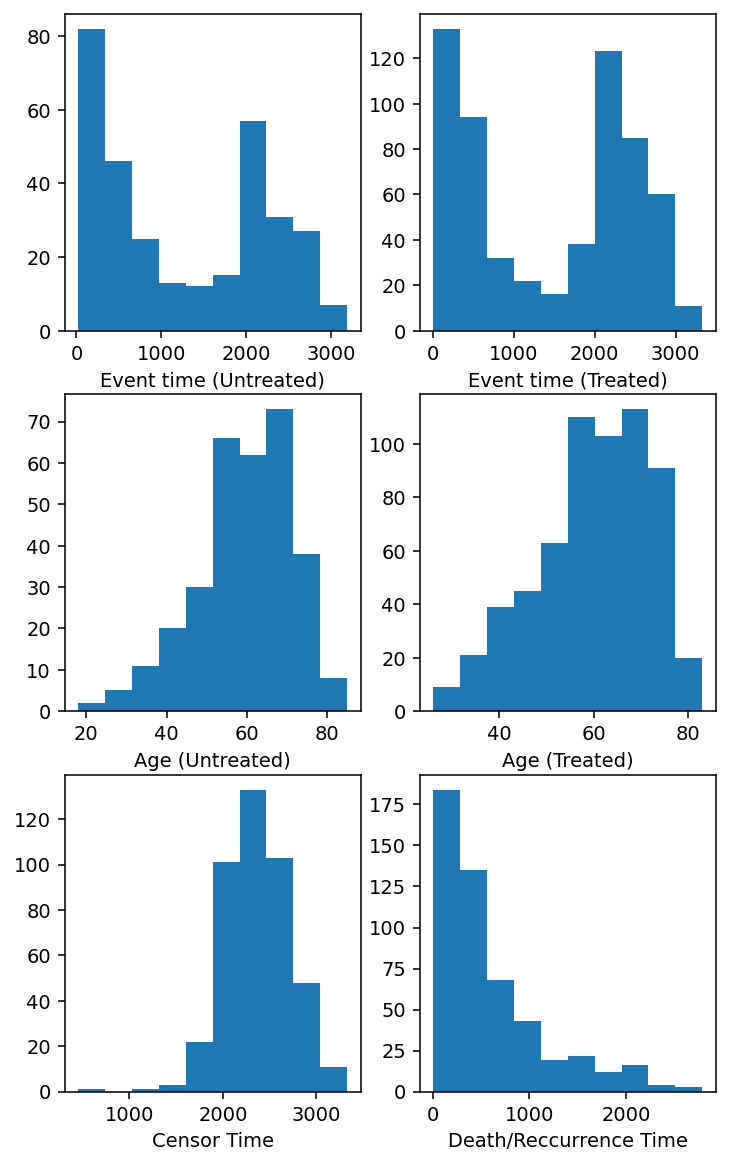

In [5]:
fig,axs = plt.subplots(nrows=3,ncols=2,figsize=(6,10))

# Plot histogram of Y0 and Y1 data
axs[0,0].hist(y0)
axs[0,0].set_xlabel("Event time (Untreated)")
axs[0,1].hist(y1)
axs[0,1].set_xlabel("Event time (Treated)")
axs[1,0].hist(X0.squeeze())
axs[1,0].set_xlabel("Age (Untreated)")
axs[1,1].hist(X1.squeeze())
axs[1,1].set_xlabel("Age (Treated)")
axs[2,0].hist(y[censor==0.])
axs[2,0].set_xlabel("Censor Time")
axs[2,1].hist(y[censor==1.])
axs[2,1].set_xlabel("Death/Reccurrence Time")


In [6]:
torch.quantile(y[censor==1.],0.9)

tensor(1473.)

In [7]:
x_test1, x_test2, _ = torch.split(X, 400, dim=0)
print(torch.median(torch.linalg.norm(x_test1 - x_test2, dim=1)))

tensor(11.)


In [8]:
# Plot Kernel for 55 year old 

In [9]:
# Set-up model
main_kernel = kernel.KGauss(sigma2=20)
    # Estimate Pseudo-Outcome Objects
adaptive_kernel = npcdf.kernel.KGauss(sigma2=10)
est_prop_func = npcdf.kernel_regressor(adaptive_kernel, min=0.1, max=0.9)
est_prop_func.fit(a, X)
est_cdf_0 = npcdf.kernel_cdf(adaptive_kernel)
est_cdf_0.fit(y0,X0)

est_cdf_1 = npcdf.kernel_cdf(adaptive_kernel)
est_cdf_1.fit(y1, X1)

model = npcdf.dr_learner(main_kernel, est_cdf_0, est_cdf_1, est_prop_func)
model.fit(y0, X0, y1, X1)

Plot results

In [10]:
# Get 10% and 90% quantiles of y0
n_grid = 50
max_data=100
quantiles = torch.tensor([0.1, 0.9])
y0_quant = (0.,1000.)
X_quant = np.quantile(X, quantiles)
test_y0 = np.linspace(y0_quant[0], y0_quant[1] ,n_grid)
test_X = np.linspace(X_quant[0], X_quant[1], n_grid)

big_X, big_y = np.meshgrid(test_X, test_y0 )
big_X_flat = torch.tensor(big_X).float().reshape(-1,1)
big_y_flat = torch.tensor(big_y).float().reshape(-1)

outlist = []
for i in range(int(np.ceil(n_grid**2/max_data))):
    temp_out = model.predict(
        big_y_flat[i*max_data:(i+1)*max_data],
        big_X_flat[i*max_data:(i+1)*max_data,:], isotonic=True)
    outlist.append(temp_out)
results = torch.cat(outlist).reshape(n_grid, n_grid)
results_diff = (torch.cat(outlist)-big_y_flat).reshape(n_grid, n_grid)

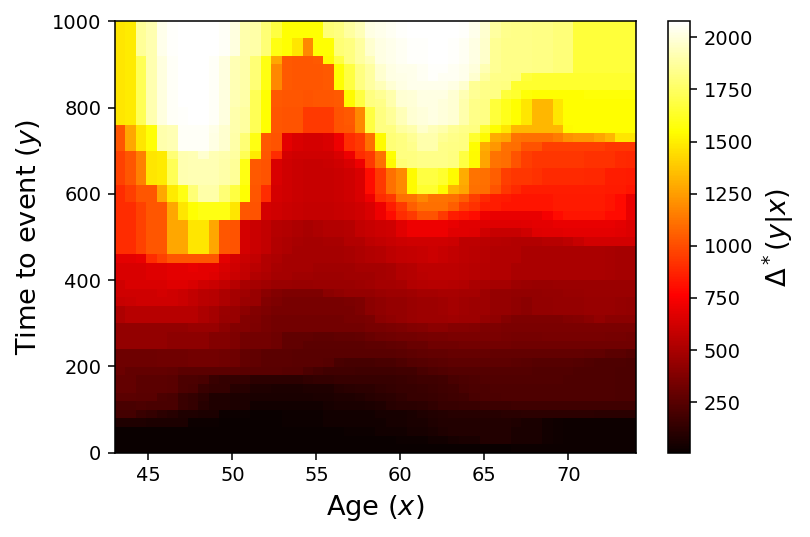

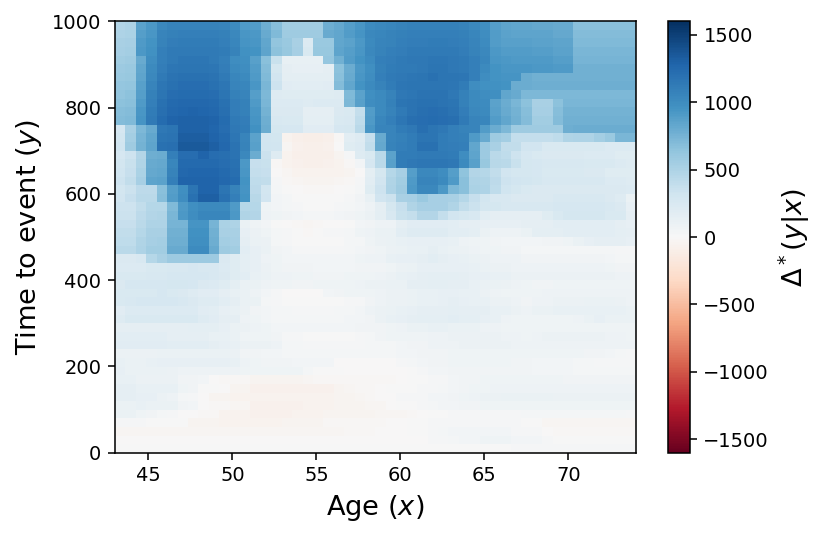

In [14]:
# Plot heatmap of the results with test_x on x-axis and test_y0 on y-axis and out as the heatmap
fig, ax = plt.subplots(figsize=(6, 4))
contour = ax.imshow(results, cmap='hot', interpolation='nearest', origin='lower',
                    extent=[X_quant[0], X_quant[1], y0_quant[0], y0_quant[1]], aspect="auto")#, vmin=-2500, vmax=40000)
fig.colorbar(contour).set_label(label=r"$\Delta^*(y|x)$", fontsize=14)
ax.set_xlabel(r"Age ($x$)", fontsize=14)
ax.set_ylabel(r"Time to event ($y$)", fontsize=14)
ax.set_title("")
fig.savefig("../Plots/Colon_g_hat_heatmap.pdf",bbox_inches='tight')

# cbar_ax = fig.add_axes([0.93, 0.11, 0.02, 0.775])  # Adjust these values as needed
# Use the last contour plot to generate the colorbar

fig, ax = plt.subplots(figsize=(6, 4))
contour_1 = ax.imshow(
    results_diff, cmap='RdBu', interpolation='nearest', origin='lower',
    extent=[X_quant[0], X_quant[1], y0_quant[0], y0_quant[1]], aspect="auto", vmin=-1600, vmax=1600)
fig.colorbar(contour_1).set_label(label=r"$\Delta^*(y|x)$", fontsize=14)
ax.set_xlabel(r"Age ($x$)", fontsize=14)
ax.set_ylabel(r"Time to event ($y$)", fontsize=14)
ax.set_title("")
fig.savefig("../Plots/Colon_g_hat-y_heatmap.pdf",bbox_inches='tight')

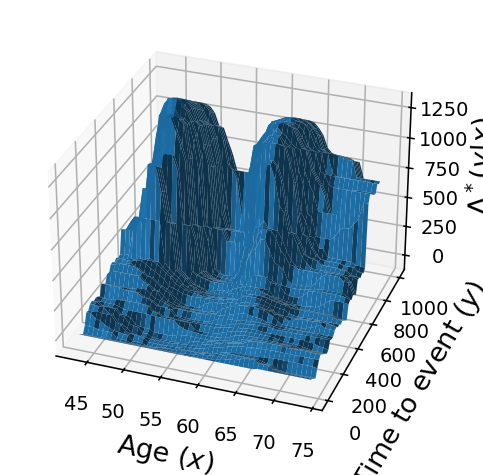

In [15]:
# Create new plot for this one
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(big_X, big_y, results_diff.numpy(), alpha=1)
# add intesecting plane at z=0 read and seethrough
# ax.plot_surface(X.numpy(), Y.numpy(), np.zeros_like(Z_g.numpy()), color="red", alpha=0.5)
ax.set_xlabel(r'Age ($x$)', fontsize=14)
ax.set_ylabel(r'Time to event ($y$)', fontsize=14)
ax.set_zlabel(r'$\Delta^*(y|x)$', fontsize=14, labelpad=5)
ax.view_init(30, -70)
extra_artists = ax.get_xaxis().get_label(), ax.get_yaxis().get_label(), ax.get_zaxis().get_label()
fig.savefig("../Plots/Colon_g_hat-y_3Dplot.pdf",bbox_inches='tight', bbox_extra_artists=extra_artists)